In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import KDTree

In [2]:
hats = pd.read_csv("data_gathering/csv_files/hat_all.csv", index_col=0)
guzergahs = pd.read_csv("data_gathering/csv_files/guzergah_all.csv", index_col=0)

In [3]:
hatkodu = hats[hats.HAT_DURUMU==1].HAT_KODU.to_numpy()

In [4]:
duraks = guzergahs[['DURAKKODU','DURAKADI','XKOORDINATI','YKOORDINATI']].drop_duplicates()

In [5]:
# dk = gpd.GeoSeries.from_wkt(duraks.KOORDINAT)
dk = gpd.GeoSeries.from_xy(duraks.XKOORDINATI, duraks.YKOORDINATI)

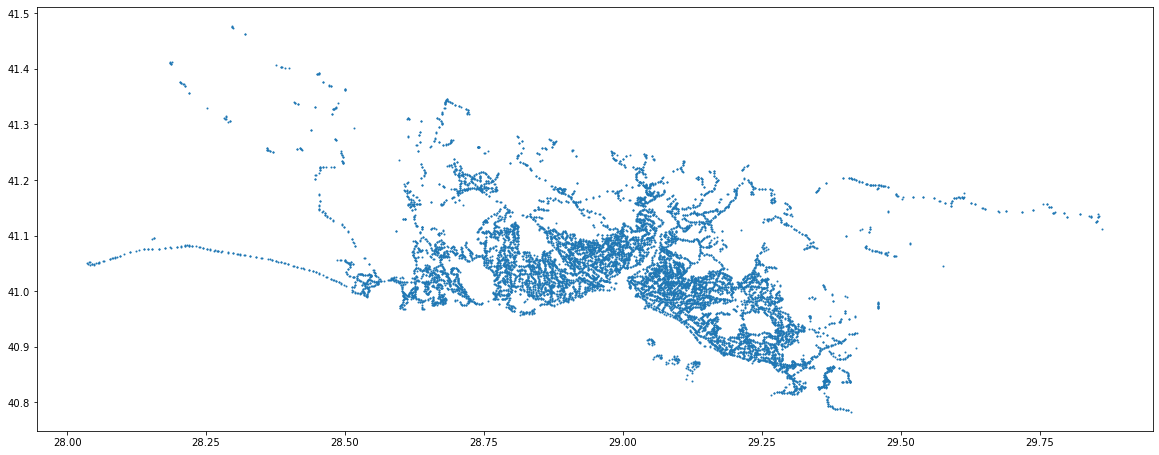

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
dk.plot(ax = ax, markersize=1)
plt.show()

In [161]:
# G = nx.DiGraph()
G = nx.Graph()
pos = {kod:(point.x, point.y) for kod, point in zip(duraks.DURAKKODU, dk)}
drk = {kod:durak for kod, durak in zip(duraks.DURAKKODU, duraks.DURAKADI)}

In [162]:
for hat in hatkodu:
    yol = guzergahs[(guzergahs.HATKODU==hat) & (guzergahs.YON=='D')]
    yol = list(zip(yol.SIRANO, yol.DURAKKODU))
    yol = sorted(yol)
    yol = [y[1] for y in yol]
    if len(yol)>1:
        yol = list(zip(yol[:-1], yol[1:]))
        G.add_edges_from(yol)
    
    yol = guzergahs[(guzergahs.HATKODU==hat) & (guzergahs.YON=='G')]
    yol = list(zip(yol.SIRANO,yol.DURAKKODU))
    yol = sorted(yol)
    yol = [y[1] for y in yol]
    if len(yol)>1:
        yol = list(zip(yol[:-1], yol[1:]))
        G.add_edges_from(yol)

In [150]:
def create_contract():
    nodepos = np.asarray([np.asarray(pos[node]) for node in G.nodes])
    tree = KDTree(nodepos)
    contract = []
    for i, node in enumerate(G.nodes):
        close = tree.query([nodepos[i]], k=2)[1][0][1]
        if drk[node] == drk[list(G.nodes)[close]]:
            pair = sorted((node, list(G.nodes)[close]))
            if pair not in contract:
                contract.append(pair)

    print("Node Count: ",len(G.nodes), "\tContract Length: ",len(contract))
    return np.asarray(contract)

In [151]:
def merge_contract_list(contract):
    contract_count = 0
    for i,(u,v) in enumerate(contract):
        contract_slice = contract[i:]
        contract_mask = (contract_slice[:,0]==v)
        contracted = contract_slice[contract_mask]
        if len(contracted>0):
            # print(contracted)
            # print(i, u, v)
            contract_count += 1
            contract_slice[contract_mask,0] = u
            contract[i:] = contract_slice
    print("Number of contract hits: ", contract_count)
    return contract

In [152]:
def merge_nodes(contract):
    for u,v in contract:
        if u in G.nodes and v in G.nodes:
            nx.algorithms.minors.contracted_nodes(G, u, v, copy=False)
    print("Node Count After Merge: ", len(G.nodes))

In [163]:
while(True):
    print("Creating contract")
    contract = create_contract()
    contract_len = len(contract)
    if(contract_len == 0):
        break
    while(True):
        print("Merging contract")
        contract = merge_contract_list(contract)
        if(contract_len == len(contract)):
            break 
        else:
            contract_len = len(contract)
    print("Merging nodes")
    merge_nodes(contract)
    print("Removing Self loops")
    print("Before Edge: ", len(G.edges))
    G.remove_edges_from(nx.selfloop_edges(G))
    print("After Edge: ", len(G.edges),"\n")

Creating contract
Node Count:  12463 	Contract Length:  5403
Merging contract
Number of contract hits:  66
Merging nodes
Node Count After Merge:  7140
Removing Self loops
Before Edge:  10064
After Edge:  9995 

Creating contract
Node Count:  7140 	Contract Length:  195
Merging contract
Number of contract hits:  4
Merging nodes
Node Count After Merge:  6951
Removing Self loops
Before Edge:  9665
After Edge:  9642 

Creating contract
Node Count:  6951 	Contract Length:  18
Merging contract
Number of contract hits:  0
Merging nodes
Node Count After Merge:  6933
Removing Self loops
Before Edge:  9598
After Edge:  9592 

Creating contract
Node Count:  6933 	Contract Length:  1
Merging contract
Number of contract hits:  0
Merging nodes
Node Count After Merge:  6932
Removing Self loops
Before Edge:  9588
After Edge:  9587 

Creating contract
Node Count:  6932 	Contract Length:  0


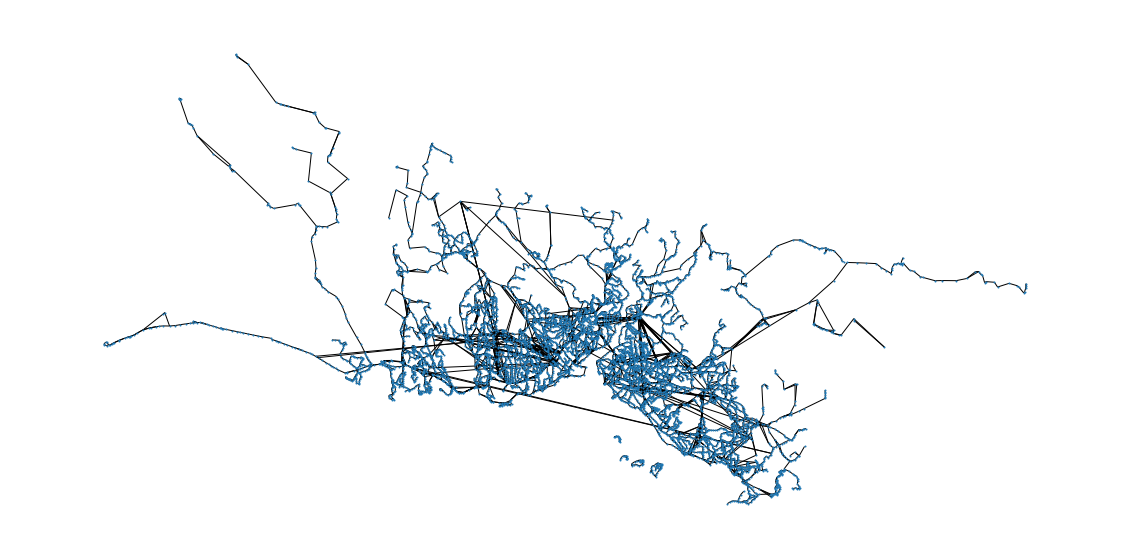

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
nx.draw(G, pos=pos, node_size=1, ax=ax)
plt.show()